In [59]:
import gc
import os
import re
import xml.etree.ElementTree as ET
from collections import Counter, defaultdict

import h5py
import joblib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from Bio import AlignIO, SeqIO
from Bio.Seq import Seq
from scipy.stats import binomtest, gaussian_kde
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from transformers import T5EncoderModel, T5Tokenizer

## Select good C-terminal alignments


In [47]:
all_aligns = AlignIO.read("ucyn-a_enriched/ucyn-a_enriched_cobalt_cleaned.fa", "fasta")

c_term_start = 880
c_term_end = 1010
align_len = c_term_end - c_term_start

good_aligns = []
good_aligns_full = []
for align in all_aligns:
    full_id = align.id
    id = " ".join(align.description.split(" ")[1:])
    align.id = id
    align.description = ""
    seq = str(align.seq)
    c_term_seq = seq[c_term_start : c_term_end + 1]
    c_term_no_gaps = "".join([char for char in c_term_seq if char != "-"])
    if len(c_term_no_gaps) / align_len > 0.6:
        good_aligns.append(
            SeqIO.SeqRecord(Seq(seq[c_term_start:]), id=id, description="")
        )
        full_seq = str(align.seq).replace("-", "")
        good_aligns_full.append(SeqIO.SeqRecord(Seq(full_seq), id=id, description=""))

SeqIO.write(good_aligns, "utp-data/good-c-term.fasta", "fasta")
SeqIO.write(good_aligns_full, "utp-data/good-c-term-full.fasta", "fasta")

206

In [46]:
c_terms_gb = list(SeqIO.parse("utp-data/good-c-term-gb.fasta", "fasta"))
ids = set([record.id for record in SeqIO.parse("utp-data/good-c-term.fasta", "fasta")])

for record in c_terms_gb:
    correct_id = next((i for i in ids if i.replace("-", "") == record.id), None)
    assert correct_id is not None
    record.id = correct_id
    record.description = ""

SeqIO.write(c_terms_gb, "utp-data/good-c-term-gb.fasta", "fasta")

AssertionError: 

## Plot relative positions of motifs


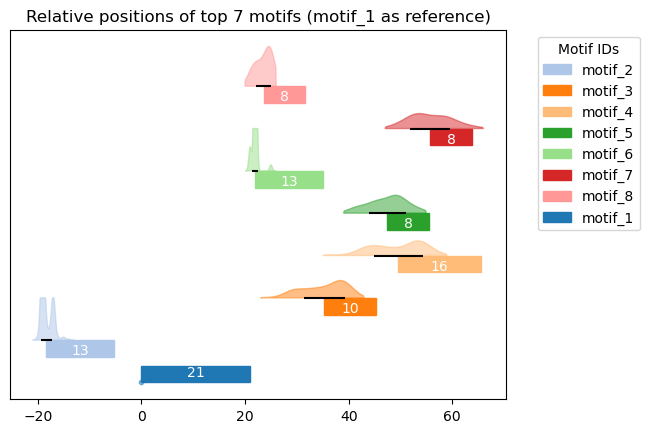

In [2]:
def parse_xml_motifs(file_path):
    meme_xml = ET.parse(file_path)
    return meme_xml


def extract_scanned_sites(meme_xml):
    sites = meme_xml.findall(".//scanned_sites")
    scanned_sites = [
        (tag.attrib["sequence_id"], site.attrib)
        for tag in sites
        for site in tag.findall("scanned_site")
    ]
    return scanned_sites


def compute_relative_positions(scanned_sites, reference_motif="motif_1"):
    motif1_positions = {
        seq: int(motif["position"])
        for seq, motif in scanned_sites
        if motif["motif_id"] == reference_motif
    }
    relative_position_occurrances = [
        (seq, motif["motif_id"], int(motif["position"]) - motif1_positions[seq])
        for seq, motif in scanned_sites
        if seq in motif1_positions and motif["motif_id"] != reference_motif
    ]
    return relative_position_occurrances


def plot_motif_positions(
    relative_position_occurrances, meme_xml, top_n=5, plot_density=True
):
    motifs = sorted(
        list(set((motif for _, motif, _ in relative_position_occurrances))),
        key=lambda motif: int(motif.split("_")[1]),
    )

    relative_positions = [[] for _ in motifs]
    for _, motif_id, rel_pos in relative_position_occurrances:
        relative_positions[motifs.index(motif_id)].append(rel_pos)

    motif_seqs = {
        tag.attrib["id"]: tag.attrib["name"] for tag in meme_xml.findall(".//motif")
    }
    cmap = matplotlib.colormaps["tab20"]
    _, ax = plt.subplots()

    for idx, motif in enumerate(motifs):
        if idx >= top_n:
            break
        rel_pos = relative_positions[motifs.index(motif)]
        mean_pos = np.mean(rel_pos)
        std_pos = np.std(rel_pos)

        base_y = idx + 1
        rect = plt.Rectangle(
            (mean_pos, base_y - 0.4),
            width=len(motif_seqs[motif]),
            height=0.4,
            color=cmap(base_y),
            label=motif,
        )
        ax.add_patch(rect)
        ax.text(
            mean_pos + len(motif_seqs[motif]) / 2,
            base_y - 0.25,
            f"{len(motif_seqs[motif])}",
            ha="center",
            va="center",
            color="white",
        )

        ax.hlines(base_y, mean_pos - std_pos, mean_pos + std_pos, color="black")

        if plot_density:
            kde = gaussian_kde(rel_pos)
            x = np.linspace(min(rel_pos) - 1, max(rel_pos) + 1, 100)
            y = kde(x) * 4
            y = np.clip(y, 0, 1)
            y[0] = 0
            y[-1] = 0
            ax.fill(x, base_y + y, color=cmap(base_y), alpha=0.5)

    # Draw reference motif
    rect = plt.Rectangle(
        (0, 0),
        width=len(motif_seqs["motif_1"]),
        height=0.4,
        color=cmap(0),
        label="motif_1",
    )
    ax.add_patch(rect)
    plt.scatter(0, 0, color=cmap(0), alpha=0.5, s=10)
    ax.text(
        len(motif_seqs["motif_1"]) / 2,
        0.25,
        f"{len(motif_seqs['motif_1'])}",
        ha="center",
        va="center",
        color="white",
    )
    # ax.vlines(len(motif_seqs["motif_1"]), 0, len(top_5_mean_positions)+1, color=cmap(0), linestyle="--", alpha=0.5)
    # ax.vlines(0, 0, len(top_5_mean_positions)+1, color=cmap(0), linestyle="--", alpha=0.5)
    
    # disable y ticks
    ax.yaxis.set_visible(False)

    ax.set_title(f"Relative positions of top {top_n} motifs (motif_1 as reference)")
    ax.legend(title="Motif IDs", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()


file_path = "utp-data/meme/meme_gb.xml"
meme_xml = parse_xml_motifs(file_path)
scanned_sites = extract_scanned_sites(meme_xml)
relative_position_occurrances = compute_relative_positions(scanned_sites)
plot_motif_positions(
    relative_position_occurrances, meme_xml, top_n=7, plot_density=True
)

## Plot the number of occurrences of each motif combination

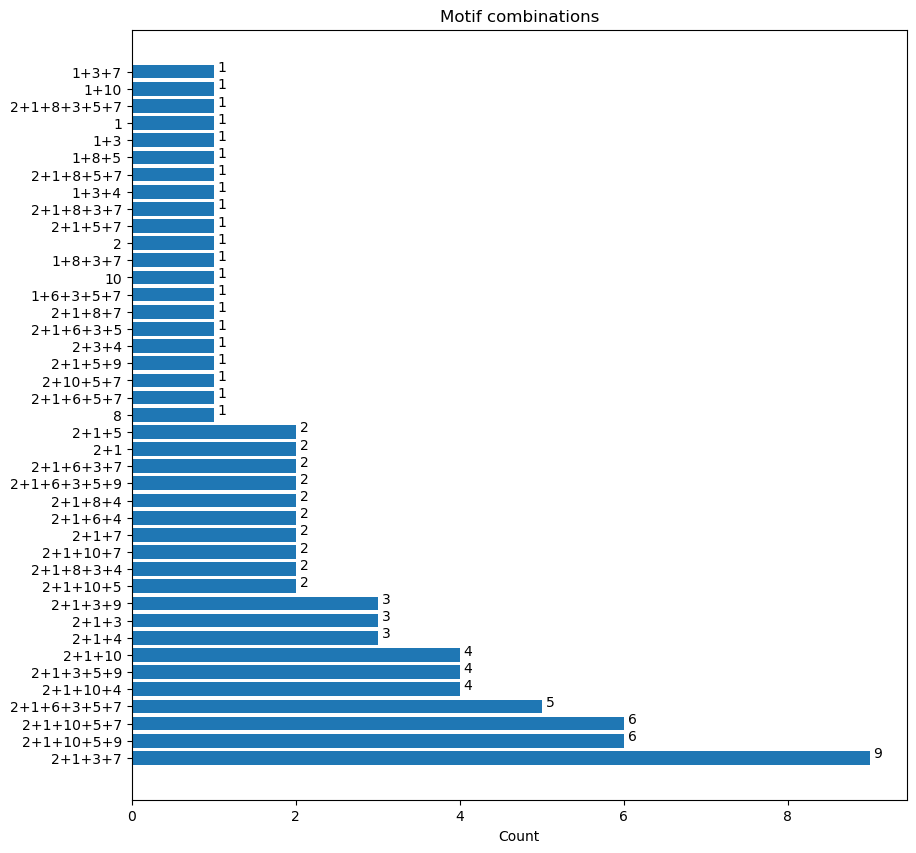

In [3]:
file_path = "utp-data/meme/meme_gb.xml"
meme_xml = parse_xml_motifs(file_path)
scanned_sites = extract_scanned_sites(meme_xml)

sequences = defaultdict(list)
for seq, motif in scanned_sites:
    sequences[seq].append(motif)
sequences = {
    seq: sorted(motifs, key=lambda motif: int(motif["position"]))
    for seq, motifs in sequences.items()
}
motif_names = {
    tag.attrib["id"]: tag.attrib["name"] for tag in meme_xml.findall(".//motif")
}

motif_combinations = [
    (seq, tuple([motif["motif_id"] for motif in motifs]))
    for seq, motifs in sequences.items()
]
motif_combination_counts = Counter(
    [tuple([motif["motif_id"] for motif in motifs]) for motifs in sequences.values()]
)
motif_combinations_ids = {
    "+".join(m.split("_")[1] for m in motifs): count
    for motifs, count in motif_combination_counts.items()
    if count < 10
}

motif_combinations_ids = dict(sorted(motif_combinations_ids.items(), key=lambda x: x[1], reverse=True))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.barh(list(motif_combinations_ids.keys()), list(motif_combinations_ids.values()))

# show counts on bars
for i, v in enumerate(motif_combinations_ids.values()):
    ax.text(v + 0.1, i, str(v), ha="center")

# ax.set_xticks(range(len(motif_combinations_ids)), list(motif_combinations_ids.keys()), rotation=60, ha="right" )

ax.set_xlabel("Count")
ax.set_title("Motif combinations")
plt.show()

## Draw the distribution of the most common motif combinations

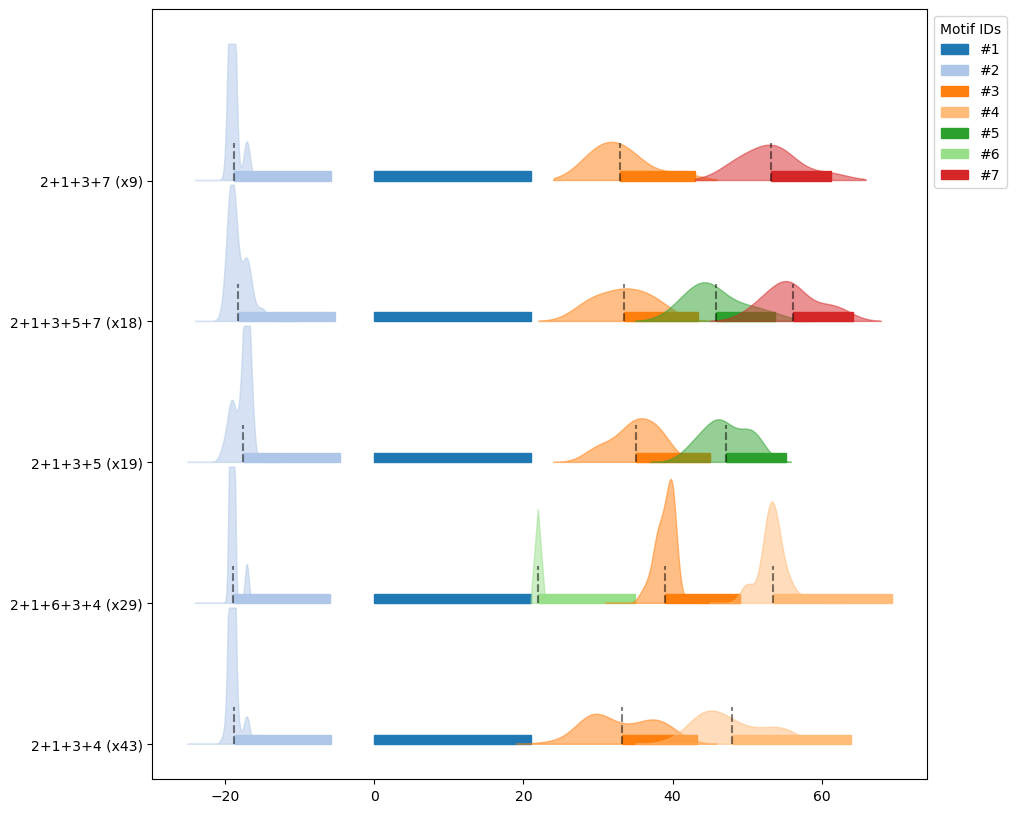

In [4]:
# Draw the most common motif combinations
top_n = 5
most_common_combinations = sorted(motif_combination_counts.keys(), key=lambda comb: motif_combination_counts[comb], reverse=True)
most_common_combinations = most_common_combinations[:top_n]

cmap = matplotlib.colormaps["tab20"]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

    
motif_seqs = {tag.attrib["id"]: tag.attrib["name"] for tag in meme_xml.findall('.//motif')}
motif_names = sorted(list(set(( m for m in motif_seqs.keys()  ))), key=lambda motif: int(motif.split("_")[1]))

yh = 1.5
for base_y, comb in enumerate(most_common_combinations):
    base_y *= yh
    # comb_name = "+".join(comb)
    # comb_count = motif_combinations[comb]
    
    comb_occurances = [ motifs for _, motifs in sequences.items() if tuple([motif["motif_id"] for motif in motifs]) == comb ]
    relative_positions = defaultdict(list)
    for motifs in comb_occurances:
        motif1 = next((motif for motif in motifs if motif["motif_id"] == "motif_1"), None)
        assert motif1 is not None, "Motif 1 not found"
        for motif in motifs:
            if motif["motif_id"] == "motif_1":
                continue
            rel_pos = int(motif["position"]) - int(motif1["position"])
            relative_positions[motif["motif_id"]].append(rel_pos)
    relative_positions = dict(relative_positions)
    
    # ax.hlins(base_y, 0, 1000, color="black", alpha=0.5)
    
    for motif in comb:
        w = len(motif_seqs[motif])
        if motif in relative_positions:
            rel_pos = np.array(relative_positions[motif])
            mean_pos = np.mean(rel_pos)
            
            motif_idx = motif_names.index(motif)
            rect = plt.Rectangle((mean_pos, base_y), width=w, height=0.1, color=cmap(motif_idx), label=motif)
            ax.add_patch(rect)
            
            ax.vlines(mean_pos, base_y, base_y + 0.4, color="black", linestyle="--", alpha=0.5)
            
            if np.all(rel_pos == rel_pos[0]):
                x = np.array([rel_pos[0] - 1, rel_pos[0], rel_pos[0] + 1])
                y = np.array([0, 1, 0])
            else:
                x = np.linspace(min(rel_pos) - 5, max(rel_pos) + 5, 100)
                kde = gaussian_kde(rel_pos)
                y = kde(x) * 4
                y = np.clip(y, 0, yh-0.05)
                y[0] = 0
                y[-1] = 0
            ax.fill(x, base_y + y, color=cmap(motif_idx), alpha=0.5, label=motif)
        else:
            rect = plt.Rectangle((0, base_y), width=w, height=0.1, color=cmap(0), label=motif)
            ax.add_patch(rect)
    

y_ticks = [ f"{'+'.join([m.split("_")[1] for m in comb])} (x{motif_combination_counts[comb]})" for comb in most_common_combinations ]
ax.set_yticks(np.arange(0, len(most_common_combinations) * yh, yh))
ax.set_yticklabels(y_ticks)

handles, labels = ax.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
unique = sorted(unique, key=lambda x: int(x[1].split("_")[1]))
unique = [(h, f"#{m.split('_')[1]}") for h, m in unique]
ax.legend(*zip(*unique), title="Motif IDs", bbox_to_anchor=(1, 1), loc="upper left")

plt.show()


## Analyze space between motifs

In [17]:
seqs = {s.id: str(s.seq) for s in SeqIO.parse("utp-data/good-c-term-full.fasta", "fasta")}

seq_names = { tag.attrib["id"]: tag.attrib["name"] for tag in meme_xml.findall('.//sequence') }
seq_motifs = { seq_name: sequences[seq_id] for seq_id, seq_name in seq_names.items() if seq_id in sequences }
seq_motifs = { seq_name: sorted(motifs, key=lambda motif: int(motif["position"])) for seq_name, motifs in seq_motifs.items() }
seq_motifs_with_pos = { seq_name: [(motif["motif_id"], int(motif["position"])) for motif in motifs] for seq_name, motifs in seq_motifs.items() }

annotated_seqs = {}
for seq_name, motifs in seq_motifs_with_pos.items():
    seq = seqs[seq_name]
    annotated_seq = []
    last_pos = -1
    for motif, pos in motifs:
        mofif_len = len(motif_seqs[motif])
        annotated_seq.append(seq[last_pos+1:pos])
        annotated_seq.append(f"[{motif}]")
        last_pos = pos+mofif_len
    annotated_seq.append(seq[last_pos+1:])
    annotated_seq = [seq for seq in annotated_seq if seq != ""]
    annotated_seqs[seq_name] = annotated_seq

in_between_motifs = defaultdict(list)
for annotated_seq in annotated_seqs.values():
    prev_motif = None
    prev_seq = None
    for seq in annotated_seq:
        if seq.startswith("["):
            motif = seq[1:-1]
            if prev_motif is not None and prev_seq is not None:
                in_between_motifs[(prev_motif, motif)].append(prev_seq)
            prev_motif = motif
        else:
            prev_seq = seq

aa_dist = { k: Counter("".join(v)) for k, v in in_between_motifs.items() }
mean_len = { k: np.mean([len(seq) for seq in v]) for k, v in in_between_motifs.items() }

In [26]:
def sample_aa_dist(n, aa_dist):
    choices = "".join([k*v for k, v in aa_dist.items()])
    aa = np.random.choice(list(choices), n)
    return "".join(aa)

In [31]:
def construct_utp(motifs_to_use):
    seq = []
    for motif1, motif2 in zip(motifs_to_use[:-1], motifs_to_use[1:]):
        seq.append(f"{motif_seqs[motif1]}")
        seq.append(sample_aa_dist(round(mean_len[(motif1, motif2)]), aa_dist[(motif1, motif2)]))
    seq.append(motif_seqs[motifs_to_use[-1]])
    return "".join(seq)

construct_utp(most_common_combinations[0])

'WLEEWRERLECWWRTEGTQTQLGACMGALGLHLGSRLDNVEIDAVPDNRIAEPGCEWVEEAEPPLPDFPEPFSLPPIPRL'

## Create motif tree

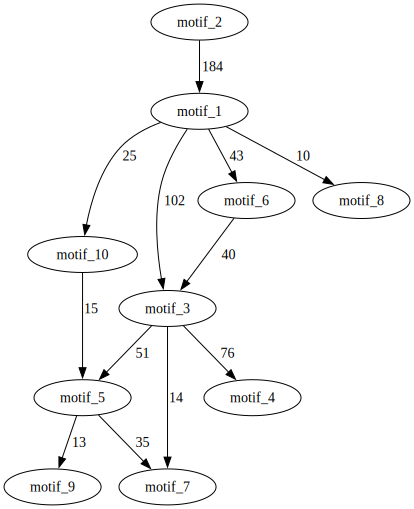

In [28]:
import graphviz

motif_tree = Counter(
    [
        (motif1["motif_id"], motif2["motif_id"])
        for motifs in sequences.values()
        for motif1, motif2 in zip(motifs[:-1], motifs[1:])
    ]
)
motif_tree = {
    (motif1, motif2): count
    for (motif1, motif2), count in motif_tree.items()
    if count > 5
}

dot = graphviz.Digraph()
for motif1, motif2 in motif_tree:
    dot.edge(motif1, motif2, label=str(motif_tree[(motif1, motif2)]))
dot

## Analyze relationship between motifs and the mature domain

In [39]:
seqs = list(SeqIO.parse("utp-data/good-c-term-full.fasta", "fasta"))

seq_names = { tag.attrib["id"]: tag.attrib["name"] for tag in meme_xml.findall('.//sequence') }
seq_motifs = { seq_name: sequences[seq_id] for seq_id, seq_name in seq_names.items() if seq_id in sequences }
seq_motifs = { seq_name: sorted(motifs, key=lambda motif: int(motif["position"])) for seq_name, motifs in seq_motifs.items() }
seq_motifs_with_pos = { seq_name: [(motif["motif_id"], int(motif["position"])) for motif in motifs] for seq_name, motifs in seq_motifs.items() }
seq_motifs = { seq_name: [motif["motif_id"] for motif in motifs] for seq_name, motifs in seq_motifs.items() }

In [48]:
# Test whether the mature domain can predict the motif sequence
mature_domains = {
    seq.id: str(seq.seq)[:c_term_start] for seq in seqs if seq.id in seq_motifs
}

dataset = [
    (mature_domains[seqid], seq_motifs[seqid]) for seqid in seq_motifs if len(seq_motifs[seqid]) > 0
]

In [58]:
tokenizer = T5Tokenizer.from_pretrained(
    "Rostlab/prot_t5_xl_uniref50", do_lower_case=False
)
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()

def embed_sequences(sequences, device="cpu"):
    feat_list = []
    for seq in tqdm(sequences):
        seq_list = []
        seq = re.sub(r"\*", "", seq)
        slen = len(seq)
        #            sequences.append(" ".join(str(fasta.seq)))
        seq_list.append(" ".join(seq))
        # map rarely occured amino acids (U,Z,O,B) to (X)
        seq_list = [
            re.sub(r"[UZOJB]", "X", sequence) for sequence in seq_list
        ]
        # Tokenize, encode seq_list and load it into the GPU if possibile
        ids = tokenizer.batch_encode_plus(
            seq_list, add_special_tokens=True, padding=True
        )
        input_ids = torch.tensor(ids["input_ids"]).to(device)
        attention_mask = torch.tensor(ids["attention_mask"]).to(device)
        # Extracting sequence features and load it into the CPU if needed
        with torch.no_grad():
            embedding = model(
                input_ids=input_ids, attention_mask=attention_mask
            )
        embedding = embedding.last_hidden_state.cpu().numpy()
        # Remove padding (\<pad>) and special tokens (\</s>) that is added by ProtT5-XL-UniRef50 model
        features = []
        for seq_num in range(len(embedding)):
            seq_len = (attention_mask[seq_num] == 1).sum()
            seq_emd = embedding[seq_num][: seq_len - 1]
            features.append(seq_emd)

        features = np.array(features).astype(float).reshape(slen, 1024)
        feat_list.append(features)
    return feat_list

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [36]:
if os.path.exists("utp-data/mature-embeddings.h5"):
    with h5py.File("utp-data/mature-embeddings.h5", "r") as f:
        mature_embeddings_unordered = []
        for key in f.keys():
            idx, _ = key.split("_", 1)
            mature_embeddings_unordered.append((idx, f[key][()]))
        mature_embeddings = [None] * len(mature_embeddings_unordered)
        for idx, feat in mature_embeddings_unordered:
            mature_embeddings[int(idx)] = feat
else:
    mature_embeddings = embed_sequences([s for s, _ in dataset])
    with h5py.File("utp-data/mature-embeddings.h5", "w") as f:
        for idx, seqid in enumerate(seq_motifs):
            if len(seq_motifs[seqid]) == 0:
                continue
            feat = mature_embeddings[idx]
            f.create_dataset(f"{idx}_{seqid}", data=feat)


### Train embeddings classifier

In [75]:
X = np.array([np.mean(feat, axis=0) for feat in mature_embeddings])

motif_labels = list(set((tuple(comb) for comb in seq_motifs.values())))
Y = np.array([ motif_labels.index(tuple(comb)) for _, comb in dataset ])
Y_counts = Counter(Y)
# use only motifs that have at least 10 occurances, 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC()
]

test_results = {}
for classifier in classifiers:
    classifier.fit(X_train, Y_train)
    
    Y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    
    n = len(Y_test)
    p = 1 / len(motif_labels)
    alternative = 'greater'
    p_value = binomtest(round(accuracy * n), n, p, alternative=alternative)
    
    test_results[classifier.__class__.__name__] = {
        "accuracy": accuracy,
        "p_value": p_value.pvalue
    }
        

for classifier, accuracy in test_results.items():
    print(f"{classifier}: {accuracy}")
    
best_embedding_classifier = max(test_results, key=lambda x: test_results[x]["accuracy"])
best_embedding_classifier = [c for c in classifiers if c.__class__.__name__ == best_embedding_classifier][0]
joblib.dump(best_embedding_classifier, "utp-data/best-embedding-classifier.joblib")

LogisticRegression: {'accuracy': 0.325, 'p_value': 2.2104365467748996e-12}
DecisionTreeClassifier: {'accuracy': 0.125, 'p_value': 0.0018654416324964521}
RandomForestClassifier: {'accuracy': 0.25, 'p_value': 1.3517005055256763e-08}
SVC: {'accuracy': 0.275, 'p_value': 8.316769727458918e-10}


['utp-data/best-embedding-classifier.joblib']

In [73]:
# count occurances of each unique value in Y
Y_counts = Counter(Y)
(Y_counts.most_common()[0][1])/sum(Y_counts.values())

0.2182741116751269

In [56]:
if os.path.exists("utp-data/best-embedding-classifier.joblib"):
    best_embedding_classifier = joblib.load("utp-data/best-embedding-classifier.joblib")

In [61]:
def predict_motifs(seq):
    feat = embed_sequences([seq])[0]
    feat = np.mean(feat, axis=0)
    pred = best_embedding_classifier.predict([feat])
    return motif_labels[pred[0]]


m_neon_green = "MVSKGEEDNMASLPATHELHIFGSINGVDFDMVGQGTGNPNDGYEELNLKSTKGDLQFSPWILVPHIGYGFHQYLPYPDGMSPFQAAMVDGSGYQVHRTMQFEDGASLTVNYRYTYEGSHIKGEAQVKGTGFPADGPVMTNSLTAADWCRSKKTYPNDKTIISTFKWSYTTGNGKRYRSTARTTYTFAKPMAANYLKNQPMYVFRKTELKHSKTELNFKEWQKAFTDVMGMDELYK"
predict_motifs(m_neon_green)

100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


('motif_2', 'motif_1', 'motif_3', 'motif_4')

In [78]:
def create_utp(seq):
    motifs = predict_motifs(seq)
    utp = construct_utp(motifs)
    full_seq = seq + utp

create_utp(m_neon_green)

100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


'WLEEWRERLECWWVLAATQTQLGACMGALGLHLGSRLDLEWTYRGTLSDQAEPGCEWVEEQELYLPDFPEPFSLPPIPRL'

### Train amino acid composition classifier

In [54]:
AA_alphabet = list("ABCDEFGHIJKLMNOPQRSTUVWYZX")

AA_comp = []
for seq in [s for s, _ in dataset]:
    aa = []
    for a in AA_alphabet:
        aa.append(seq.count(a))
    AA_comp.append(aa)
AA_comp = np.array(AA_comp)

(197, 26)

In [56]:
X = AA_comp
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

classifiers = [
    # LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC()
]

test_results = {}
for classifier in classifiers:
    classifier.fit(X_train, Y_train)
    
    Y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    
    n = len(Y_test)
    p = 1 / len(motif_labels)
    alternative = 'greater'
    p_value = binomtest(round(accuracy * n), n, p, alternative=alternative)
    
    test_results[classifier.__class__.__name__] = {
        "accuracy": accuracy,
        "p_value": p_value.pvalue
    }
        

for classifier, accuracy in test_results.items():
    print(f"{classifier}: {accuracy}")
    
best_classifier = RandomForestClassifier()

DecisionTreeClassifier: {'accuracy': 0.075, 'p_value': 0.058996511791500186}
RandomForestClassifier: {'accuracy': 0.2, 'p_value': 2.4216833200738525e-06}
SVC: {'accuracy': 0.175, 'p_value': 2.6188259288855507e-05}
